### Imports and constants

In [ ]:
import os
from PIL import Image
import json
import numpy as np
from pprint import pprint
import tqdm

output_dir = 'kenney_modular_characters'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
assets_dir = 'assets/kenney_new'
modules_order = [
    'Neck',
    'Head',
    'Arm_L',
    'Arm_R',
    'Hand_L',
    'Hand_R',
    'Leg_L',
    'Leg_R',
    'Shirt_L',
    'Shirt_R',
    'Shirt',
    'Shoes_L',
    'Shoes_R',
    'Pants_L',
    'Pants_R',
    'Pants',
    'Face',
    'Hair'
    ]


### To update all the offsets

In [ ]:
modules_offsets_file = 'assets/kenney_new/modules_offsets.json'
middle_x = 0
middle_y = 0
if os.path.exists(modules_offsets_file):
    with open(modules_offsets_file, 'r') as f:
        offsets = json.load(f)
    f.close()
for class_name, offset in offsets.items():
    offsets[class_name] = (offset[0]+middle_x, offset[1]+middle_y)
#save the offsets to a file
with open(modules_offsets_file, 'w') as f:
    json.dump(offsets, f, indent=4)
f.close()

### Utils functions

In [2]:
def flip_images(images, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for image in images:
        output_path = f"{output_dir}/{os.path.basename(image)}"
        img = Image.open(image)
        flipped_img = img.transpose(Image.FLIP_LEFT_RIGHT)
        flipped_img.save(output_path)
        print(f'Flipped image saved: {image.replace(".png", "_flipped.png")}')
        

In [95]:
def sort_paths_by_order(paths:list[str], order:list[str]) -> list[str]:
    """
    Sorts the list of paths based on the predefined order.
    """
    order_dict = {name: index for index, name in enumerate(order)}
    return sorted(paths, key=lambda path: order_dict.get(path.split('/')[-2], float('inf')))


In [ ]:
def merge_composents(image_paths: list[str], output_path:str, save=True) -> Image:
    offsets = json.load(open('assets/kenney_new/modules_offsets.json', 'r'))
    
    
    image_paths = sort_paths_by_order(image_paths, modules_order)
    images = [Image.open(path) for path in image_paths]
    # Calculate the width and height of the merged image
    total_width = 600
    total_height = 600
    middle_x = 0
    middle_y = 0

    # Create a new image with the appropriate size
    merged_image = Image.new('RGBA', (total_width, total_height))

    # Paste each image into the merged image
    for i, img in enumerate(images):
        class_name = image_paths[i].split('/')[-2]
        special_type = os.path.basename(image_paths[i]).split('.')[0].split('_')[-1]
        try:
            class_offsets = offsets.get(class_name, {'standard':(0, 0)})
            x_offset, y_offset = class_offsets.get(special_type, class_offsets['standard'])
        except Exception as e:
            print(f"Error with the offset file (should contain a 'standard' value for each class) : {e}")
            x_offset, y_offset = 0, 0
            continue
        merged_image.alpha_composite(img, (x_offset + middle_x, y_offset + middle_y))
    # Save the merged image
    if save:
        output_dir = os.path.dirname(os.path.abspath(output_path))
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        merged_image.save(output_path)
        
    return merged_image



In [4]:
def generate_random_character(assets_dir: str, output_path: str, logic=True, save=True) -> Image:
    """
    Generates a random character by merging components from the assets directory.
    """
    image_paths = []
    classes = [d for d in os.listdir(assets_dir) if os.path.isdir(os.path.join(assets_dir,d))]

    if logic:
        head = np.random.choice([f'{assets_dir}/Head/{f}' for f in os.listdir(f'{assets_dir}/Head') if f.endswith('.png')])
        tint = os.path.basename(head).split('_')[0]
        arm_L = f'{assets_dir}/Arm_L/{tint}_arm.png'
        arm_R = f'{assets_dir}/Arm_R/{tint}_arm.png'
        neck = f'{assets_dir}/Neck/{tint}_neck.png'
        hand_L = f'{assets_dir}/Hand_L/{tint}_hand.png'
        hand_R = f'{assets_dir}/Hand_R/{tint}_hand.png'
        leg_L = f'{assets_dir}/Leg_L/{tint}_leg.png'
        leg_R = f'{assets_dir}/Leg_R/{tint}_leg.png'
        
        pants_L = np.random.choice([f'{assets_dir}/Pants_L/{f}' for f in os.listdir(f'{assets_dir}/Pants_L') if f.endswith('.png')])
        pants_R = f'{assets_dir}/Pants_R/{os.path.basename(pants_L)}'
        pants_color = os.path.basename(pants_L).split('_')[0]
        pants = np.random.choice([f'{assets_dir}/Pants/{f}' for f in os.listdir(f'{assets_dir}/Pants') if f.endswith('.png') and pants_color in f])
        
        shirt_L = np.random.choice([f'{assets_dir}/Shirt_L/{f}' for f in os.listdir(f'{assets_dir}/Shirt_L') if f.endswith('.png')])
        shirt_R = f'{assets_dir}/Shirt_R/{os.path.basename(shirt_L)}'
        shirt_color = os.path.basename(shirt_L).split('_')[0][:-3]
        shirt = np.random.choice([f'{assets_dir}/Shirt/{f}' for f in os.listdir(f'{assets_dir}/Shirt') if f.endswith('.png') and shirt_color in f])
        
        shoe_L = np.random.choice([f'{assets_dir}/Shoes_L/{f}' for f in os.listdir(f'{assets_dir}/Shoes_L') if f.endswith('.png')])
        shoe_R = f'{assets_dir}/Shoes_R/{os.path.basename(shoe_L)}'
        
        hair = np.random.choice([f'{assets_dir}/Hair/{f}' for f in os.listdir(f'{assets_dir}/Hair') if f.endswith('.png')])
        face = np.random.choice([f'{assets_dir}/Face/{f}' for f in os.listdir(f'{assets_dir}/Face') if f.endswith('.png')])
        image_paths = [head, arm_L, arm_R, neck, leg_L, leg_R, hand_L, hand_R, pants, pants_L, pants_R, shirt, shirt_L, shirt_R, shoe_L, shoe_R, hair, face]
    else: 
        for class_name in classes:
            class_dir = f'{assets_dir}/{class_name}'
            if os.path.isdir(class_dir):
                images = [f'{class_dir}/{f}' for f in os.listdir(class_dir) if f.endswith('.png')]
                if images:
                    image_paths.append(np.random.choice(images))  # Take the first image from each class directory
    assert len(image_paths) == len(classes)                
    merged_image = merge_composents(image_paths, output_path, save=save)
    return merged_image, image_paths

In [99]:
def generate_dataset(assets_dir:str, output_path):
    characters = []
    
    heads = [f'{assets_dir}/Head/{f}' for f in os.listdir(f'{assets_dir}/Head') if f.endswith('.png')]
    hairs = [f'{assets_dir}/Hair/{f}' for f in os.listdir(f'{assets_dir}/Hair') if f.endswith('.png')][0:15]
    faces = [f'{assets_dir}/Face/{f}' for f in os.listdir(f'{assets_dir}/Face') if f.endswith('.png')][0:1]
    shoes = [f'{assets_dir}/Shoes_L/{f}' for f in os.listdir(f'{assets_dir}/Shoes_L') if f.endswith('.png')][0:1]
    pants_L = [f'{assets_dir}/Pants_L/{f}' for f in os.listdir(f'{assets_dir}/Pants_L') if f.endswith('.png')]
    shirts_L = [f'{assets_dir}/Shirt_L/{f}' for f in os.listdir(f'{assets_dir}/Shirt_L') if f.endswith('.png')]
    
    for head in tqdm.tqdm(heads, desc='Heads :'):
        tint = os.path.basename(head).split('_')[0]
        arm_L = f'{assets_dir}/Arm_L/{tint}_arm.png'
        arm_R = f'{assets_dir}/Arm_R/{tint}_arm.png'
        neck = f'{assets_dir}/Neck/{tint}_neck.png'
        hand_L = f'{assets_dir}/Hand_L/{tint}_hand.png'
        hand_R = f'{assets_dir}/Hand_R/{tint}_hand.png'
        leg_L = f'{assets_dir}/Leg_L/{tint}_leg.png'
        leg_R = f'{assets_dir}/Leg_R/{tint}_leg.png'
        
        for hair in tqdm.tqdm(hairs, desc='Hairs :'):
            for face in faces:
                for shoe_L in shoes:
                    shoe_R = f'{assets_dir}/Shoes_R/{os.path.basename(shoe_L)}'
                    
                    for pant_L in pants_L:
                        pant_R = f'{assets_dir}/Pants_R/{os.path.basename(pant_L)}'
                        pants_color = os.path.basename(pant_L).split('_')[0]
                        pants = [f'{assets_dir}/Pants/{f}' for f in os.listdir(f'{assets_dir}/Pants') if f.endswith('.png') and pants_color in f]
                        for pant in pants:
                            for shirt_L in shirts_L:
                                shirt_R = f'{assets_dir}/Shirt_R/{os.path.basename(shirt_L)}'
                                shirt_color = os.path.basename(shirt_L).split('_')[0][:-3]
                                shirts = [f'{assets_dir}/Shirt/{f}' for f in os.listdir(f'{assets_dir}/Shirt') if f.endswith('.png') and shirt_color in f][0:1]
                                for shirt in shirts:
                                    image_paths = [head, arm_L, arm_R, neck, leg_L, leg_R, hand_L, hand_R, pant, pant_L, pant_R, shirt, shirt_L, shirt_R, shoe_L, shoe_R, hair, face]
                                    # print(len(heads)*len(hairs)*len(shoes)*len(pants_L)*len(pants)*len(shirts_L)*len(shirts)*len(faces))
                                    characters.append(image_paths)
                                     
    with open(output_path,mode='w') as f:
        json.dump(characters,f, indent=4)
        

### Main cell

In [100]:
dataset_path = f'{assets_dir}/Dataset.json'
generate_dataset(assets_dir=assets_dir,output_path=dataset_path)

Heads :: 100%|██████████| 8/8 [01:09<00:00,  8.74s/it]


In [101]:
dataset = json.load(open(f'{assets_dir}/Dataset.json',mode='r'))
print(f'Loaded dataset with {len(dataset)} charaters of {len(dataset[0])} modules')

Loaded dataset with 414720 charaters of 18 modules


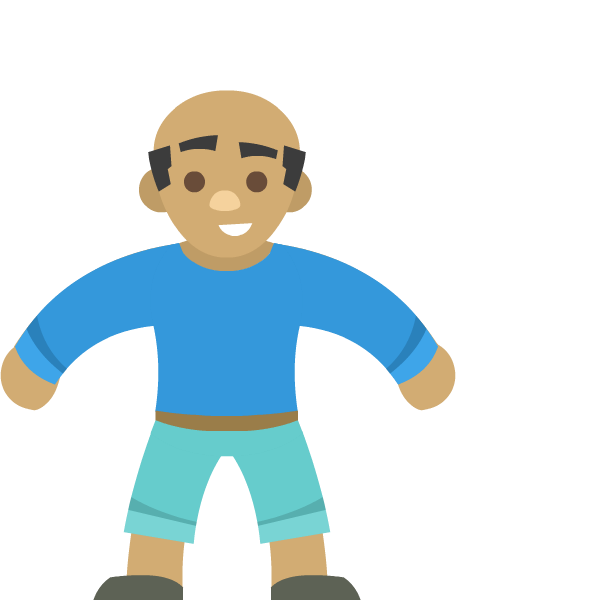

['assets/kenney_new/Head/tint5_head.png',
 'assets/kenney_new/Arm_L/tint5_arm.png',
 'assets/kenney_new/Arm_R/tint5_arm.png',
 'assets/kenney_new/Neck/tint5_neck.png',
 'assets/kenney_new/Leg_L/tint5_leg.png',
 'assets/kenney_new/Leg_R/tint5_leg.png',
 'assets/kenney_new/Hand_L/tint5_hand.png',
 'assets/kenney_new/Hand_R/tint5_hand.png',
 'assets/kenney_new/Pants/pantsLightBlue4.png',
 'assets/kenney_new/Pants_L/pantsLightBlue_short.png',
 'assets/kenney_new/Pants_R/pantsLightBlue_short.png',
 'assets/kenney_new/Shirt/blueShirt_1.png',
 'assets/kenney_new/Shirt_L/blueArm_long.png',
 'assets/kenney_new/Shirt_R/blueArm_long.png',
 'assets/kenney_new/Shoes_L/blackShoe1.png',
 'assets/kenney_new/Shoes_R/blackShoe1.png',
 'assets/kenney_new/Hair/black_Man8.png',
 'assets/kenney_new/Face/face_1.png']


In [141]:
character = dataset[np.random.randint(len(dataset))]
output_path = 'merged_image.png'
image = merge_composents(image_paths=character, output_path=output_path,save=False)
display(image)
pprint(character)